In [14]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

# if "../" not in sys.path:
#   sys.path.append("../")

from collections import defaultdict
from collections import namedtuple
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [5]:
# load env
env = CliffWalkingEnv()

## Test Interaction with the Environment

In [6]:
# step walk to test the env
print(env.reset())
env.render()

print(env.step(0))
env.render()

print(env.step(1))
env.render()

print(env.step(1))
env.render()

print(env.step(2))
env.render()

print(env.step(1)) # the env itself cannot reset the states
env.render()

36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

(24, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(25, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(26, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(38, -100.0, True, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  x  C  C  C  C  C  C  C  C  T

(39, -100.0, True, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  x  C  C  C 

## Off-Policy Control with Q-Learning


In [7]:
# behavior policy: epsilon-greedy
def behaviorPolicyEpsilonGreedy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policyFn(observation):
        A_probs = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A_probs[best_action] += (1.0 - epsilon)
        return A_probs
    return policyFn

In [21]:
# Off-policy control with Q-Learning
class Stats:
    def __init__(self, num_episodes):
        self.reset(num_episodes)
    def reset(self, num_episodes):
        self.episode_lengths = np.zeros(num_episodes)
        self.episode_rewards = np.zeros(num_episodes)

def qLearning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = np.zeros([env.nS, env.action_space.n])

    # Keeps track of useful statistics
    stats = Stats(num_episodes)
    
    # The policy we're following
    policy = behaviorPolicyEpsilonGreedy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():  # very useful for condition iteration
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [22]:
# start Q-Learning
Q, stats = qLearning(env, 500)
count = np.sum(stats.episode_lengths)
print("Action Set Size:", env.nA, ', count =', count)
print("Optimal Action-Value Function (row-label: state, column-label: action):")
print(Q)

Episode 500/500.Action Set Size: 4 , count = 7578.0
Optimal Action-Value Function (row-label: state, column-label: action):
[[-12.83535656 -12.61002344 -12.9147773  -13.        ]
 [-11.87533379 -11.81492433 -11.75965389 -12.81870648]
 [-11.265625   -11.03808081 -11.15126081 -11.42836103]
 [-10.5        -10.14824006 -10.5601046  -10.20047229]
 [ -9.5         -9.25778751  -9.65332919  -9.75906495]
 [ -8.80022826  -8.34424553  -8.64117798  -9.06287575]
 [ -7.5         -7.48762045  -7.40537713  -8.00808418]
 [ -6.96252734  -6.63679587  -6.63494361  -7.70972329]
 [ -6.19604492  -5.71890704  -5.85538236  -6.54897645]
 [ -5.          -4.84019549  -4.86669984  -5.61262834]
 [ -4.          -3.93645154  -3.93866031  -4.04296875]
 [ -3.375       -3.61934114  -2.99434114  -3.640625  ]
 [-13.18284622 -12.58757783 -12.5200709  -12.75      ]
 [-12.23965703 -11.87757881 -11.92682376 -12.21410708]
 [-11.13510158 -10.95009951 -10.93806934 -12.30480439]
 [-10.04973887  -9.98179155  -9.98349676 -10.839711

In [17]:
# Act using Learned Q Value Function
iter_num = 1
for i_episode in range(iter_num):
    observation = env.reset() # observation here is state ID.
    print(observation)
    count = 0
    while True:
        count += 1
        env.render() # plot the current state of the env
        action = np.argmax(Q[observation])
        observation, reward, done, info = env.step(action)
        print(observation, reward, done, info)
        if done:
            env.render()
            print("Episode {}/{} finished after {} timesteps".format(i_episode+1, iter_num, count))
            break

36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

24 -1.0 False {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

25 -1.0 False {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

26 -1.0 False {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

27 -1.0 False {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

28 -1.0 False {'prob': 1.0}
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

29 -1.0 Fal

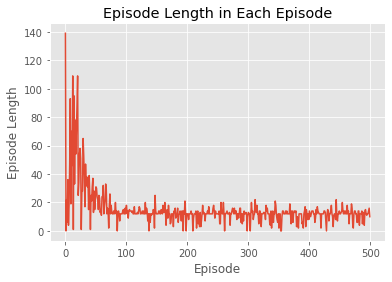

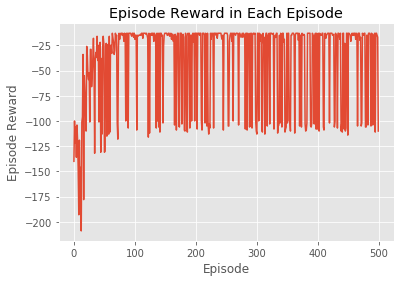

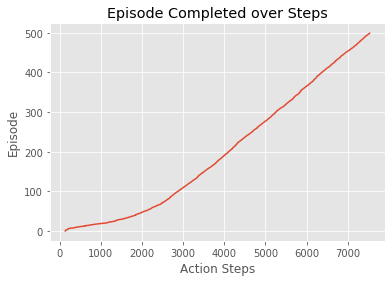

In [16]:
# plot
def plotEpisodeLength(stats, figuresize=(8,6), noshow=False):
    # Plot the episode length over time
    fig = plt.figure()
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length in Each Episode")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)
        
def plotReward(stats, figuresize=(8,6), noshow=False):
    # Plot the episode length over time
    fig = plt.figure()
    plt.plot(stats.episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward in Each Episode")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)
        
def plotEpisodeNumOverSteps(stats, figuresize=(8,6), noshow=False):
    # Plot time steps and episode number
    fig = plt.figure()
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Action Steps")
    plt.ylabel("Episode")
    plt.title("Episode Completed over Steps")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

plotEpisodeLength(stats)
plotReward(stats)
plotEpisodeNumOverSteps(stats)